In [1]:
# Standard Machine Learning Imports
import pandas as pd 
# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
os.listdir()
# Text Precrocessing standard imports
import nltk
# nltk.download()
from nltk.corpus import stopwords
import re
import string
from scipy.sparse import csr_matrix,csc_matrix,coo_matrix,lil_matrix
print("Directory of Files:\n",os.listdir())

Directory of Files:
 ['.ipynb_checkpoints', '3 - Naive Bayes - Movie Reviews.ipynb', 'aclImdb', 'aclImdb_v1.tar.gz', 'xliw17.pdf']


In [3]:
# # The data is in a tarfile, which needs to be used in the working directory
import tarfile
filename = "aclImdb_v1.tar.gz"
tf = tarfile.open(filename)
tf.extractall()

In [4]:
# Open up all of the files in the positive and negative folders in the training data folder
import glob 

# Need to encode the text as utf-8
enc = 'utf-8'

# Path to positive txt reviews
pos_paths = ["aclImdb/train/pos/*.txt", "aclImdb/test/pos/*.txt"]

# Positive review files for Dataframe
positive_reviews = []

# List of file names to open and store into a dataframe for processing
for pos_path in pos_paths:
    files = glob.glob(pos_path)
    for file in files:
        txt = open(file, encoding=enc).read()
        positive_reviews.append(txt)
    
# Path to the negative txt reviews
neg_paths = ["aclImdb/train/neg/*.txt", "aclImdb/test/neg/*.txt"]

# Positive review files for Dataframe
negative_reviews = []

# List of file names to open and store into a dataframe for processing
for neg_path in neg_paths:
    files = glob.glob(neg_path)
    for file in files:
        txt = open(file, encoding=enc).read()
        negative_reviews.append(txt)
    
    

In [5]:
def preprocess_text(txt):
    '''Lower the text'''
    txt = txt.lower()
    '''Remove the <br /><br /> in each review'''
    txt = txt.replace("<br /><br />","")
    '''Remove the stopwords from a string of text'''
    words = txt.split()
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]
    '''Remove the stopwords from a list of words'''
    stop_words = set(stopwords.words('english'))
    stripped = [word for word in stripped if word not in stop_words]
    return ' '.join(stripped)

def concat_docs(all_txt_files):
    '''Parameters
    all_txt_files, … iterable containing strings

    Returns
    concatenated_docs
    The concatenated strings.'''
    try:
        _ = (e for e in all_txt_files)
    except TypeError:
        raise TypeError(all_txt_files, 'is not iterable')
        
    return " ".join(all_txt_files)


In [6]:
# Reviews into a dataframe for preprocessing

# Targets for the training data
targets = [1]*len(positive_reviews) + [0]*len(negative_reviews)
# Reviews
revs = positive_reviews+negative_reviews
reviews_dataframe = pd.DataFrame({'reviews': revs, 'targets':targets})

# Print the head of the dataframe
reviews_dataframe.head()

,reviews,targets
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [7]:
# Use CountVectorizer to organize the data
from sklearn.feature_extraction.text import CountVectorizer
# Preprocces the reviews
reviews_dataframe['reviews_processed'] = reviews_dataframe['reviews'].apply(lambda x: preprocess_text(x))

vect = CountVectorizer()
reviews = vect.fit_transform(reviews_dataframe['reviews_processed'])


5859849


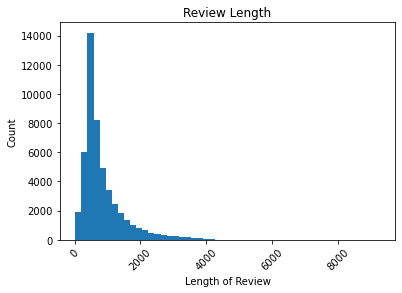

In [8]:
# Plot the Length of each review 

reviews_length_array = reviews_dataframe['reviews_processed'].apply(lambda x: len(x)).values

plt.title("Review Length")
plt.hist(reviews_length_array,bins=50)
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Length of Review')
plt.show()

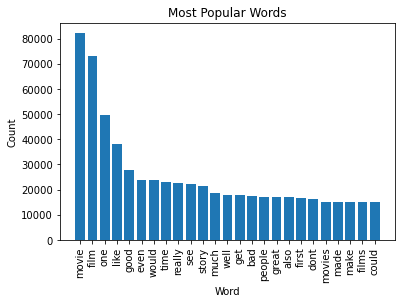

In [9]:
# Examine the top unigrams using count venctorizer

num_words = 25

word_count_vector = reviews.sum(axis=0)
word_count_tuples = [(word,word_count_vector[0,word_feature_idx]) for word,word_feature_idx in vect.vocabulary_.items()]

popular_words = sorted(word_count_tuples,key=lambda x: x[1], reverse=True)[:num_words]

words = [i[0] for i in popular_words]
counts = [i[1] for i in popular_words]

plt.bar(words,counts)
plt.title("Most Popular Words")
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.xlabel('Word')
plt.show()

In [10]:
# Get the Length of the Dataframe
N = len(reviews_dataframe)
print(f"Length of the Dataframe: {N} reviews")

Length of the Dataframe: 49102 reviews


In [11]:
# Seperate Targets in the dataframe
targets = reviews_dataframe['targets'].values

In [12]:
# Get an Idea of the size of each array
print("Shape of reviews array: ",reviews.shape)
print("Shape of targets array: ",targets.shape)

Shape of reviews array:  (49102, 218862)
Shape of targets array:  (49102,)


In [13]:
# Split the Data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews, targets, test_size=0.33)

In [79]:
# Use the MultinomialNB classifier for this dataset
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
start = time.time()
classifer = MultinomialNB()
classifer.fit(X_train,y_train)
predictions = classifer.predict(X_test)
print(time.time() - start)
print("Classifer Score for MultinomialNB: ", accuracy_score(y_test,predictions))


0.08282184600830078
Classifer Score for MultinomialNB:  0.8551592199456924


In [80]:
class MultinomialBayesianClassifier():
    
    def __init__(self, alpha=1):
        self.alpha = alpha
        

    def get_total_words_by_class(self):
        # Concatonate the Features and Targets to split the array by classes
        
        sum_1 = self.X.sum(axis=1)
        tar = np.reshape(self.y, (self.N, 1))
        self.count_words_by_class = {cls:0 for cls,_ in self.priors.items()}
        for t,s in zip(tar, sum_1):
            self.count_words_by_class[t[0]] += s[0,0]
        
        return self.count_words_by_class
    
    def feature_count(self):
        
        # get the likelihood of the words by class (counts of each word given class)
        likelihood_counts = lil_matrix((len(self.priors.keys()),self.D))
        
        for cls in self.priors.keys():
            likelihood_counts[cls,:] = self.X[self.y==cls].sum(axis=0)
        
        return csr_matrix(likelihood_counts)
    
    
    def get_prior_counts(self):
        # Calculat the count of each class
        prior_counts = {}
        target_values, counts = np.unique(self.y,return_counts=True)
        for val,count in zip(target_values, counts):
            prior_counts[val] = count
        return prior_counts
    
    def get_prior_proba(self):
        # Calculate the Prior Probability of each class
        priors = {t:v/self.N for t,v in self.prior_counts.items()}
        return priors
    
    def get_feature_log_proba(self):
        
        log_proba = lil_matrix((len(self.priors.keys()), self.D))
        
        for cls in self.priors.keys():
            t = ((self.feature_counts_[cls,:].toarray() + 1)/(self.total_words_by_class[cls]+self.D))
            log_proba[cls,:] = np.log(t)
            
        return log_proba.toarray()
    
    def predict(self,X_t):
        
        # Make predictions using linear algebra
        predictions = X_t.dot(self.feature_log_proba.T)
        priors = np.array([np.log(self.priors[cls]) for cls in self.priors.keys()])
        predictions = np.argmax(predictions+priors,axis=1)
        
        return predictions
           
    
    def fit(self,X,y):
        
        # Input should be a matrix of count frequencies and targets
        # X should be a count vectorizer instance 
        # y is a 1-D array 
        
        self.X = X
        self.y = y
        
        # Dimensions of the Dataset
        self.N, self.D = X.shape
        
        # Count of each Class
        self.prior_counts = self.get_prior_counts()
        
        # Prior Probabilibies
        self.priors = self.get_prior_proba()
        
        # Get the total number of words in each class for the naive bayes formula
        self.total_words_by_class = self.get_total_words_by_class()
        
        # Feature counts of the dataset
        self.feature_counts_ = self.feature_count()
        
        # Vocab Size for Smoothing
        self.vocab_size_ = self.D
        
        # Log Probability for features Nclass x D
        self.feature_log_proba = self.get_feature_log_proba()
        


In [83]:
import time
classifier = MultinomialBayesianClassifier()
classifier.fit(X_train,y_train)

preds = classifier.predict(X_test)

# Accuracy Score
c=0
N ,_ = X_test.shape
for i,j in zip(preds,y_test):
    if i==j:
        c+=1
print("Accuracy",c/N)

# This is the Same exact score as the sklearn version

Accuracy 0.8551592199456924
